In [6]:
# Import basic data analysys libraries 

import pandas as pd 
import time
from datetime import datetime
import matplotlib.pyplot as plt

# Import Python CoinGecko API for data extraction from the exchange  


from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

# Part 1. Data extraction

In [2]:
# get a list of all exchangable coints on CoinGecko 

coins = pd.DataFrame(cg.get_coins_markets(vs_currency  = 'usd'))
list_of_coins = coins.id.to_list()

In [7]:
# defifing a function for extraction closing daily prices
# for each crypto the interval is [intoduction date ; today]

def get_price_by_name(name):
    try:
        data = cg.get_coin_market_chart_by_id(id = name, vs_currency = 'usd', days = 'max')
        df = pd.DataFrame(data["prices"]).rename(columns={0: "timestamp", 1: name})
        df["timestamp"] = pd.to_datetime(df['timestamp'], unit='ms').dt.date
        return df.groupby("timestamp").mean(name)
    except:
        return name

In [4]:
# merging price series

def merge_prices(names):
    df = get_price_by_name(names[0])
    for name in names[1:]:
        add = get_price_by_name(name)
        df = pd.merge(df, add, left_index=True, right_index=True, how="outer")
    return df

In [6]:
result = merge_prices(list_of_coins)
result.sort_values(by=['timestamp'], ascending=False).to_excel("btc_daiy.xlsx")
result

,bitcoin,ethereum,tether,binancecoin,cardano,dogecoin,ripple,usd-coin,polkadot,uniswap,...,ontology,bancor,harmony,wazirx,siacoin,husd,the-graph,liquity-usd,0x,curve-dao-token
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-04-28,135.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-29,141.960000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,135.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-01,117.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-02,103.430000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-07,35834.474474,2711.547939,1.002578,392.026501,1.680627,0.372499,0.941946,1.003415,24.145890,25.849305,...,1.102458,4.468048,0.096161,1.742646,0.018906,1.001019,0.780875,1.012106,1.057977,2.450192
2021-06-08,33451.383407,2580.535580,1.000276,356.261415,1.553100,0.333077,0.854522,0.999390,21.397393,23.998197,...,0.981262,4.184070,0.086449,1.541511,0.016461,0.985865,0.690665,1.014092,0.945279,2.131184
2021-06-09,33557.150683,2528.022301,1.002423,353.762400,1.581410,0.327442,0.875760,1.002264,21.865194,23.506062,...,0.967788,4.115797,0.086290,1.552109,0.016202,1.001977,0.696306,1.015430,0.952766,2.350663


# Part 2. Download and prepare VIX and EPU

In [ ]:
import datetime
import ciso8601
import time

In [7]:
# VIX was downloaded from "https://www.cboe.com/tradable_products/vix/vix_historical_data/"

vix = pd.read_csv('VIX_History.csv')
vix = vix[['DATE','CLOSE']]
vix.DATE = vix.DATE.apply(mdydatetime)


# EPU was downloaded form "https://www.policyuncertainty.com"

epu = pd.read_csv('USEPUINDXD.csv')
epu = epu[['DATE', 'USEPUINDXD']]
epu.info
epu.DATE = epu.DATE.apply(dmydatetime)

# Merging epu and vix with left merge
# EPU is not measured on weekends and US holidays, thats why we use left merge on VIX and "bfill" function. 
# Backwards fill replaces every NaN value with the closest previous values in the column

res = epu.merge(vix, on = "DATE", how = "left")
res.fillna(method='bfill', inplace=True)
res.to_excel('result_vix_epu.xlsx')

# Part 3. Convert daily prices to daily logarithmic returns 

In [ ]:
# define a function for conversion to log retuns 

def logr(series):
    res = []
    for i in range(len(series)):
        try:
            temp = (np.log(1 + (series[i]/series[i-1])))
        except:
            temp = 0
        res.append(temp)
    return res

In [ ]:
# convert every column from our dataset except timestamp data, VIX, EPU

for crypto in try1.columns[3:]:
    try1[crypto] = logr(try1[crypto])

# Extras and Visualization 

In [ ]:
# short script to determine number of cryptoassets which have length over sertain number 

length = 1000
count = 0
lst = []
for i in df.columns[4:]:
    if 2912 - df[i].isna().sum() > length:
        count += 1
        lst.append(i)
print('OVER ' + str(length) + ' OBSERVATIONS')
print(str(count) + " TOTAL COUNT")
print(lst)

In [2]:
df = pd.read_excel('/Users/tima/Desktop/baza/crypto/data/data_00.xlsx')

In [3]:
# get correlation coeficient  
correlation = pd.DataFrame(columns = ['VIX', 'EPU'])
correlation.VIX = df.VIX
correlation.EPU = df.EPU
correlation.corr()

,VIX,EPU
VIX,1.000000,0.638413
EPU,0.638413,1.000000


In [4]:
# graph for correlation of VIX and EPU
ts = df.timestamp
df.drop('timestamp', inplace = True, axis = 1)
df_normalized = df / df.max(axis=0)
df_normalized['ts'] = ts

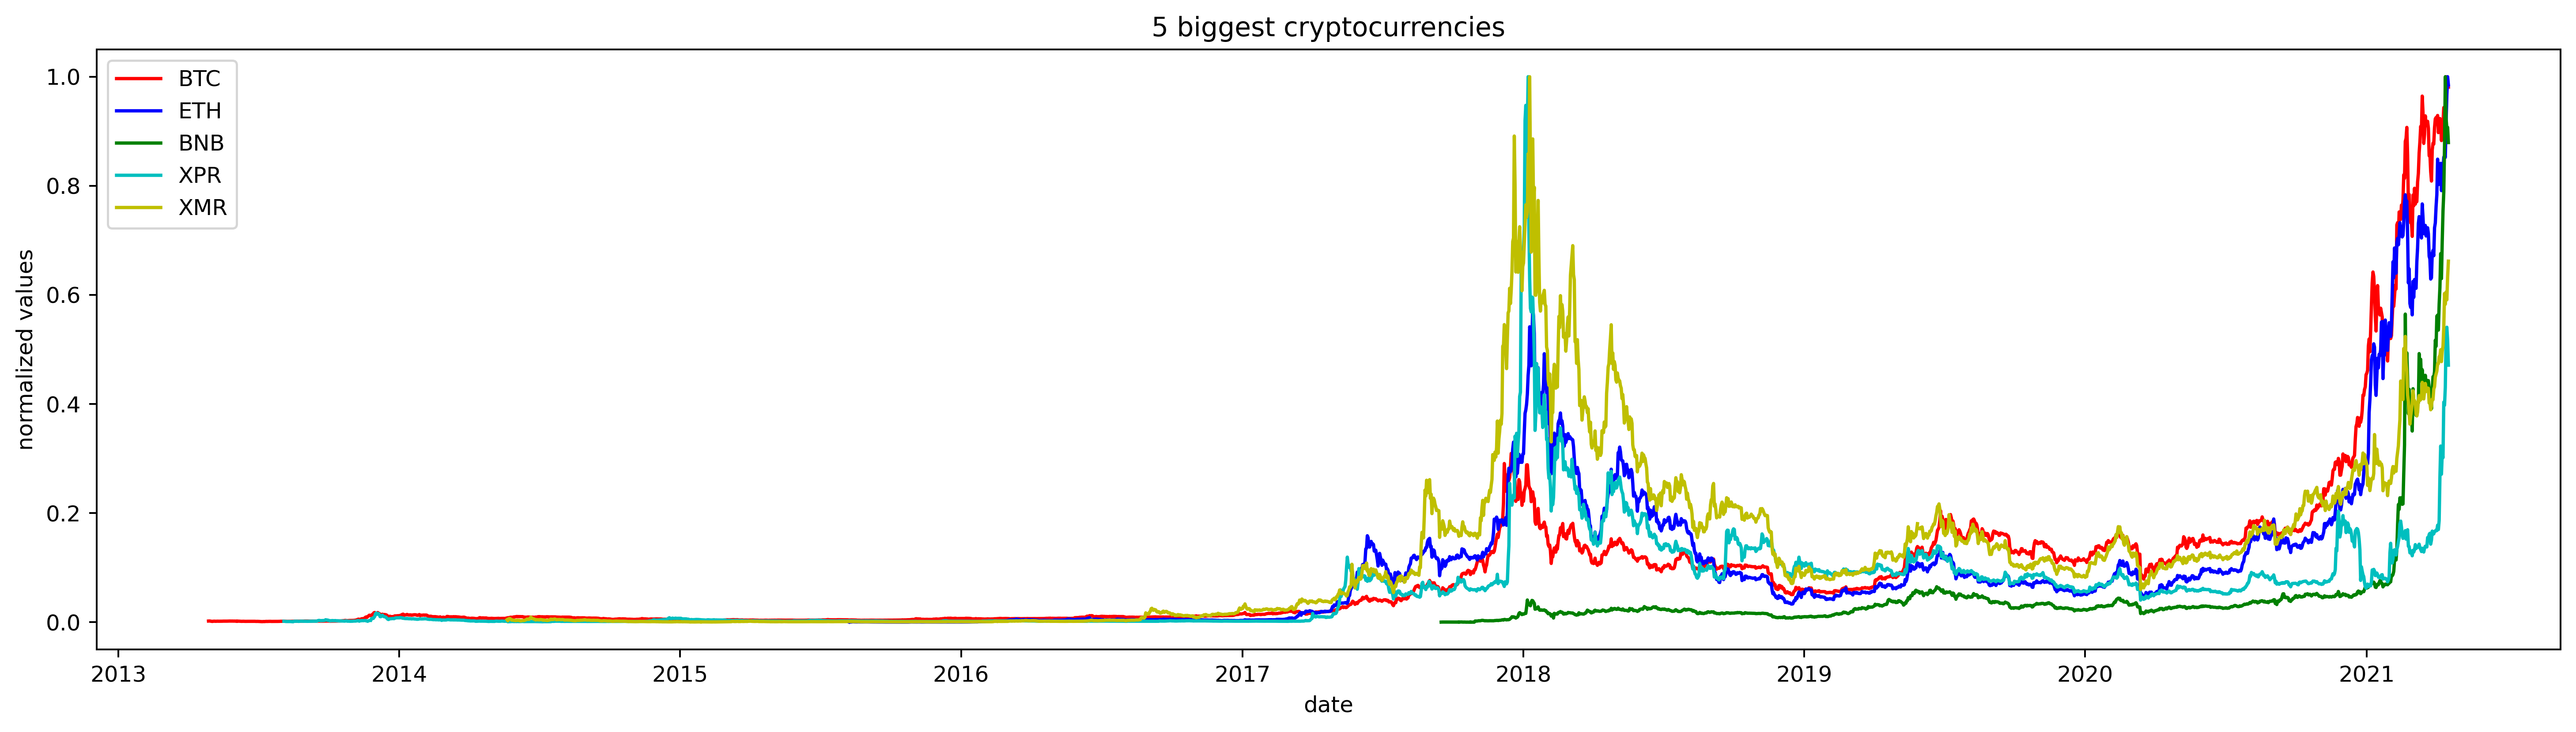

In [7]:
plt.figure(figsize=(20, 5), dpi=360)
plt.title("5 biggest cryptocurrencies")
plt.xlabel('date')
plt.ylabel('normalized values')
plt.plot(df_normalized.ts, df_normalized.bitcoin, c = 'r', label = 'BTC')
plt.plot(df_normalized.ts, df_normalized.ethereum, c = 'b', label = 'ETH')
plt.plot(df_normalized.ts, df_normalized.binancecoin, c = 'g', label = 'BNB')
plt.plot(df_normalized.ts, df_normalized.ripple, c = 'c', label = 'XPR')
plt.plot(df_normalized.ts, df_normalized.monero, c = 'y', label = 'XMR')
plt.legend(['BTC', 'ETH', 'BNB', 'XPR', 'XMR'], loc='upper left')
plt.savefig('biggest_cryptos.png')

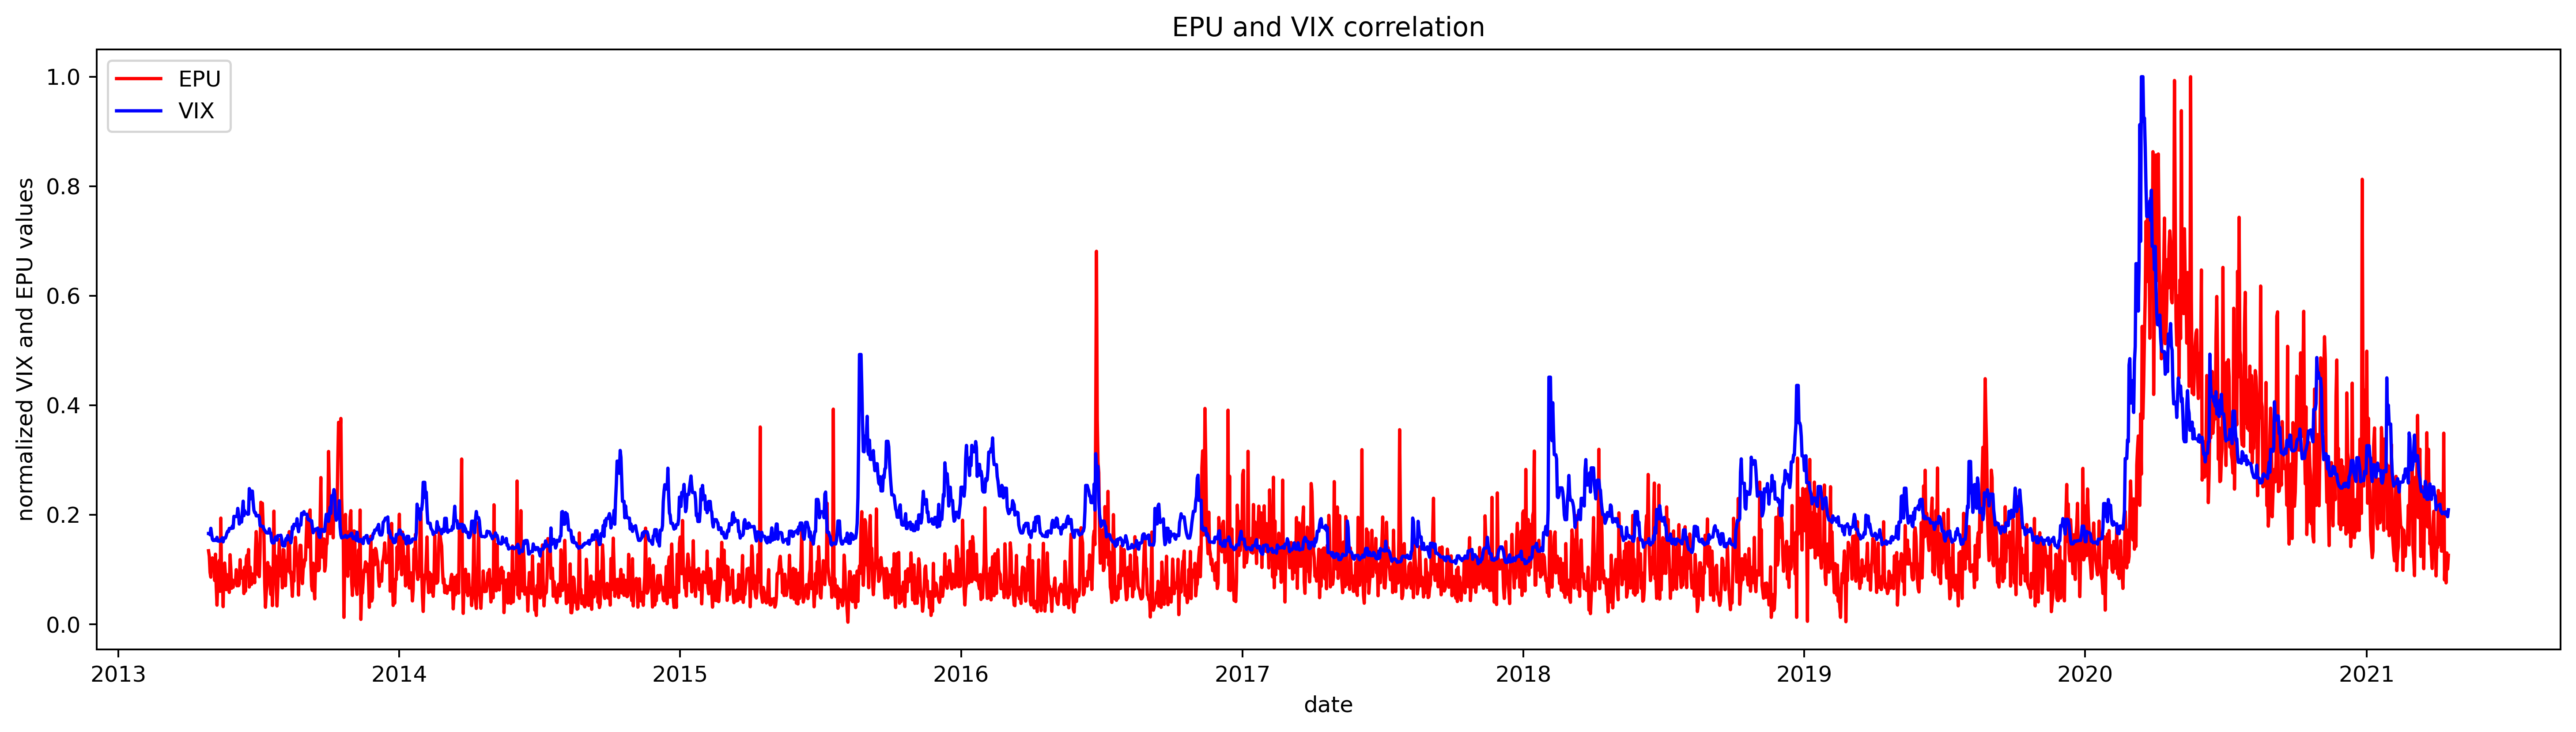

In [9]:
plt.figure(figsize=(20, 5), dpi=360)
plt.title("EPU and VIX correlation")
plt.xlabel('date')
plt.ylabel('normalized VIX and EPU values')
plt.plot(df_normalized.ts, df_normalized.EPU, c = 'r')
plt.plot(df_normalized.ts, df_normalized.VIX, c = 'b')
plt.legend(['EPU', 'VIX'], loc='upper left')
plt.savefig('epu_vix.png')